# Introduction

Dans le domaine complexe de la finance de marché, des intuitions simples peuvent souvent mener à des idées profondes et puissantes. Dans ce notebook, nous allons explorer une de ces intuitions : l'impact de la volatilité sur l'autocorrélation des rendements.

La volatilité des marchés financiers peut engendrer des comportements de panique chez les investisseurs. Cette panique, alimentée par la peur de manquer une opportunité (FOMO, Fear Of Missing Out) ou par la crainte d'importantes pertes, peut créer des cycles de vente ou d'achat qui accentuent la volatilité. C'est un phénomène bien connu lors des krachs boursiers, où la précipitation des ventes peut intensifier la chute des marchés.

Notre hypothèse est que lors de ces périodes de forte volatilité, l'autocorrélation des rendements, qu'elle soit positive ou négative, augmente également. Si c'est le cas, nous pourrions utiliser cette relation pour améliorer nos prédictions des rendements futurs.

Pour explorer cette idée, nous allons combiner deux types de modèles statistiques. Tout d'abord, nous utiliserons un modèle GARCH (Generalized Autoregressive Conditional Heteroskedasticity) pour prédire la volatilité. Les modèles GARCH sont couramment utilisés en finance pour modéliser et prévoir la volatilité des rendements.

Une fois que nous aurons une prévision de la volatilité, nous utiliserons un modèle autoregressif (AR) pour prédire les rendements futurs. L'idée est que si la volatilité prévue est élevée, et donc que l'autocorrélation est susceptible d'être plus forte, alors le modèle AR pourrait être plus précis dans ses prévisions.

En combinant ces deux approches, nous espérons créer un modèle de prévision de rendement qui tient compte de la dynamique de la volatilité et de l'autocorrélation. Cela pourrait nous donner un avantage dans la prédiction des mouvements du marché, nous permettant d'ajuster nos stratégies de trading en conséquence.

Entrons maintenant dans le vif du sujet et commençons notre analyse.


In [5]:
import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from fracdiff import fdiff
from fracdiff.sklearn import FracdiffStat
import MetaTrader5 as mt5
from arch import arch_model
import matplotlib.colors as mcolors
import sys
sys.path.append(r'C:\Users\ftiag\Desktop\Business, trading et investissement\Business\modules')
from research_tools import get_clean_mt5_data, frac_func_close, MultipleTimeSeriesCV, rank_correl
from sklearn.metrics import make_scorer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

mt5.initialize()

login_mt5 = 1051534030
mdp_mt5 = 'FG2SF2M74R'
server = 'FTMO-Demo'

mt5.login(login_mt5, mdp_mt5, server)

True

Dans ce bloc de code, nous préparons nos données et mettons en œuvre notre modèle GARCH pour prédire la volatilité des rendements de chaque paire de devises.

La première partie du code est similaire à ce que nous avons vu précédemment : nous récupérons les données de prix des paires de devises spécifiées et calculons les rendements logarithmiques. L'utilisation du logarithme pour calculer les rendements a plusieurs avantages, notamment une meilleure symétrie et une stabilité numérique. Le facteur de 10000 est appliqué pour améliorer la convergence du modèle GARCH sans dénaturer l'information contenue dans les données.

Nous définissons ensuite la taille de notre ensemble d'entraînement (`train_size`) et initialisons une liste vide (`rolling_predictions`) pour stocker nos prédictions de volatilité.

Ensuite, pour chaque paire de devises dans nos données, nous entraînons un modèle GARCH sur les `train_size` derniers rendements, puis nous utilisons ce modèle pour prédire la volatilité du prochain rendement. Notez que nous utilisons un modèle GARCH(1,1), qui est le modèle GARCH le plus simple, avec un seul terme autoregressif et un seul terme de moyenne mobile.

Pour chaque prédiction, nous stockons le symbole de la paire de devises, la date de la prédiction, la volatilité prédite et la valeur du paramètre omega du modèle. Omega est le terme constant dans l'équation GARCH et représente la variance conditionnelle à long terme.

Finalement, nous convertissons notre liste de prédictions en un DataFrame pandas et définissons le symbole et la date comme index.

Ce bloc de code nous donne donc un ensemble de prédictions de volatilité pour chaque paire de devises, que nous pourrons utiliser dans la suite de notre analyse.

In [6]:
tickers = ['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']
currencies = get_clean_mt5_data(tickers, interval=mt5.TIMEFRAME_H4, n_bars=6700).close.unstack(0)

In [7]:
returns = np.log(currencies / currencies.shift(1)).dropna() * 10000

In [8]:
train_size = 300
rolling_predictions = []
for ticker in returns.columns:
    print(f'fitting the model for {ticker}')
    for i in range(train_size, len(returns)+1):
        train = returns[ticker].iloc[i-train_size:i]
        model = arch_model(train, p=1, q=1)
        model_fit = model.fit(disp='off')
        omega = model_fit.params.omega
        pred = model_fit.forecast(horizon=1, reindex=False)
        rolling_predictions.append([ticker, pred.variance.index[0], np.sqrt(pred.variance.values[-1, :][0]), np.sqrt(omega)])

rolling_predictions = pd.DataFrame(rolling_predictions, columns=['symbol', 'datetime', 'volatility', 'omega'])

fitting the model for EURGBP
fitting the model for EURUSD
fitting the model for GBPJPY
fitting the model for GBPUSD
fitting the model for USDCAD
fitting the model for USDJPY


In [9]:
rolling_predictions = rolling_predictions.set_index(['symbol', 'datetime'])

In [10]:
rolling_predictions

volatility     omega
symbol datetime                                 
EURGBP 2019-05-09 12:00:00   14.085430  2.106791
       2019-05-09 16:00:00   13.799807  2.046129
       2019-05-09 20:00:00   13.559932  1.991235
       2019-05-10 00:00:00   13.557215  1.940664
       2019-05-10 04:00:00   13.204132  1.878940
...                                ...       ...
USDJPY 2023-06-15 20:00:00   22.798016  4.927466
       2023-06-16 00:00:00   22.651159  5.024384
       2023-06-16 04:00:00   22.864773  5.195289
       2023-06-16 08:00:00   22.943230  5.363401
       2023-06-16 12:00:00   22.739075  5.503692

[38400 rows x 2 columns]

Dans ce bloc de code, nous préparons nos données pour visualisation et générons un graphique de la distribution de la volatilité pour chaque paire de devises. L'objectif de cette visualisation est de comparer les distributions de volatilité entre les différentes paires de devises pour identifier des similitudes ou des différences.

Tout d'abord, nous décalons les rendements d'un pas dans le temps et les reformons pour qu'ils correspondent au format de nos prédictions de volatilité. Nous combinons ensuite ces rendements décalés avec nos prédictions de volatilité dans un DataFrame unique.

Nous utilisons ensuite le module de visualisation seaborn pour générer des estimations de la densité du noyau (KDE) de la volatilité pour chaque paire de devises. Les KDE nous offrent une estimation lisse de la distribution de la volatilité, ce qui facilite la comparaison entre les différentes paires de devises.

Le graphique résultant nous permet d'observer si les distributions de volatilité sont similaires ou différentes entre les différentes paires de devises. Si elles sont similaires, nous pourrions envisager d'effectuer une analyse par quantiles sur toutes les paires à la fois. Cependant, si elles sont différentes, comme c'est le cas ici, nous devrons estimer les quantiles spécifiquement pour chaque paire de devises. 

Bien que les distributions diffèrent en termes de moments (c'est-à-dire de moyenne, de variance, de skewness et de kurtosis), elles présentent toutes une forme qui ressemble à une distribution log-normale. Cela signifie que, bien qu'elles soient différentes, elles partagent une certaine structure de base qui peut nous donner des indications sur la nature de la volatilité dans ces marchés de devises.

In [11]:
shift_returns = returns.shift(-1).dropna().stack().swaplevel().sort_index().to_frame().rename({0: 'returns_shift'}, axis=1)

In [12]:
shift_returns = pd.concat([shift_returns, rolling_predictions], join='inner', axis=1)

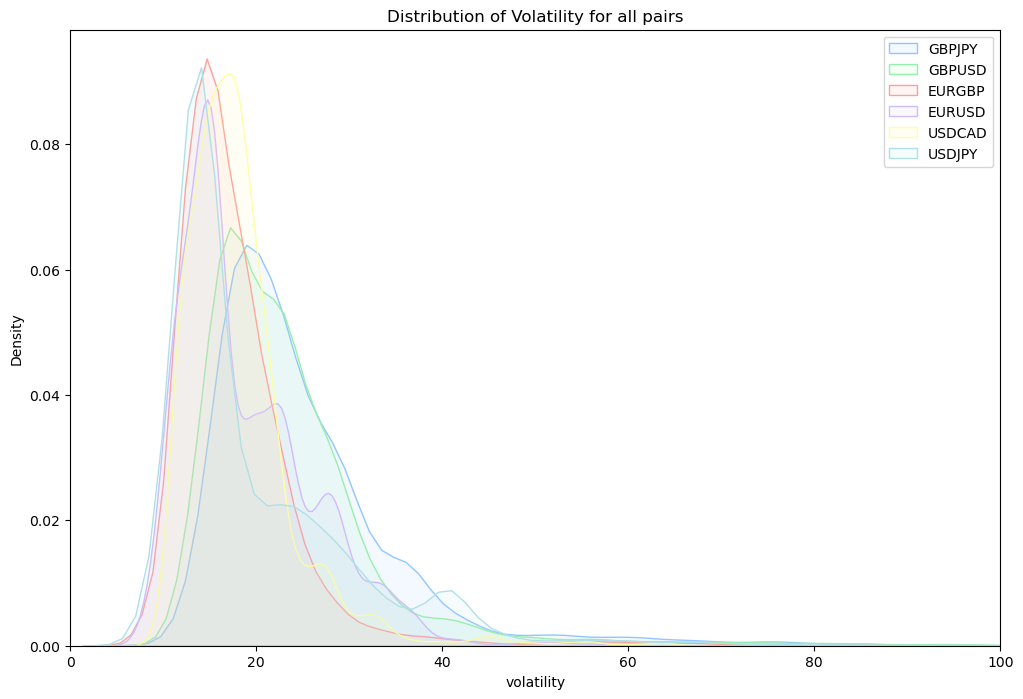

In [13]:
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(12, 8))


for ticker in tickers:
    sns.kdeplot(shift_returns.loc[ticker].volatility, label=ticker, fill=True, alpha=0.1)

plt.title('Distribution of Volatility for all pairs')
plt.xlim([0, 100])
plt.legend()

Dans ce bloc de code, nous examinons les autocorrélations de nos rendements en fonction de différents niveaux de volatilité. L'idée ici est de tester notre hypothèse selon laquelle la volatilité plus élevée conduit à une plus grande autocorrélation dans les rendements.

D'abord, nous générons des versions décalées de nos rendements avec des décalages allant de 1 à 20. Ces rendements décalés nous permettront de calculer l'autocorrélation à différents délais.

Ensuite, nous définissons une fonction, `get_filtered_df`, qui filtre nos données pour inclure uniquement les observations où la volatilité prédite est supérieure à un certain quantile. Cette fonction sera utilisée pour isoler les observations avec des niveaux de volatilité plus élevés.

Nous créons ensuite un dictionnaire, `df_plot_corr`, pour stocker les autocorrélations moyennes pour chaque quantile de volatilité. Nous calculons ces autocorrélations en filtrant nos données pour chaque quantile, puis en calculant la corrélation entre les rendements décalés et les rendements actuels. Nous prenons la valeur absolue de ces corrélations pour nous concentrer sur la force de l'autocorrélation, indépendamment de sa direction.

Enfin, nous générons un graphique en barres de ces autocorrélations moyennes pour chaque quantile de volatilité. La couleur des barres est déterminée par un dégradé allant du bleu clair au bleu foncé, représentant l'augmentation du quantile de volatilité.

Le graphique résultant illustre clairement que plus le quantile de volatilité est élevé, plus l'autocorrélation est forte. Cela conforte notre hypothèse selon laquelle une volatilité plus élevée entraîne une plus grande autocorrélation dans les rendements. Cette observation pourrait avoir des implications importantes pour les stratégies de trading basées sur les prédictions de volatilité.

In [201]:
lags = list(range(1, 21, 1))
for lag in lags:
    shift_returns[f'returns_shift_{lag}'] = shift_returns.groupby(level=0, group_keys=False).apply(lambda x: x.returns_shift.shift(lag))
shift_returns.dropna(inplace=True)

In [202]:
def get_filtered_df(thresh, df):
    mappage = dict(df.groupby(level=0).quantile(thresh).volatility)
    mask = df.volatility > df.index.get_level_values('symbol').map(mappage)
    df_filtered = df[mask]
    return df_filtered

In [203]:
df_plot_corr = {}
for thresh in np.linspace(0.05, 0.95, 10):
    df_plot_corr['quantile ' + str(round(thresh, 3))] = get_filtered_df(thresh, shift_returns).corr().abs().loc['returns_shift_1':, 'returns_shift'].mean()
    
df_plot_corr = pd.Series(df_plot_corr)

Text(0.5, 1.0, 'Absolute correlation by Volatility quantile')

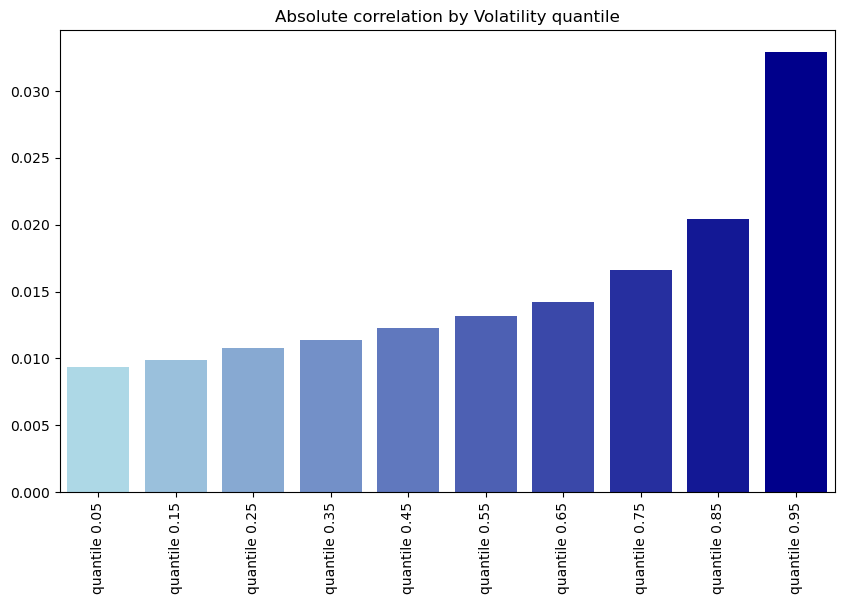

In [204]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["lightblue", "darkblue"])
plt.figure(figsize=(10, 6))
df_plot_corr.plot.bar()
plt.bar(df_plot_corr.index, df_plot_corr, color=cmap(np.linspace(0, 1, len(df_plot_corr))))
plt.title('Absolute correlation by Volatility quantile')

Dans ce bloc de code, nous élargissons l'analyse pour inclure un ensemble de données plus large, comprenant un plus grand nombre de paires de devises. Nous utilisons également un modèle d'apprentissage automatique, la régression Ridge, pour prédire les rendements futurs en fonction des rendements passés. 

D'abord, nous définissons la liste des paires de devises que nous allons inclure dans notre analyse. Nous récupérons ensuite les données de prix pour ces paires à l'aide de notre fonction `get_clean_mt5_data` et calculons les rendements.

Nous préparons nos données pour la modélisation en créant une colonne de retard pour chaque décalage dans notre liste `lags`. Nous utilisons ensuite une pipeline comprenant un `StandardScaler` pour normaliser nos données et un modèle `Ridge` pour effectuer la régression.

Nous utilisons une stratégie de validation croisée personnalisée pour former et tester notre modèle. Cette stratégie est basée sur la classe `MultipleTimeSeriesCV`, qui est une modification de la classe fournie dans le livre "Machine Learning for Algorithmic Trading". Cette classe est spécifiquement conçue pour effectuer une validation croisée sur plusieurs séries temporelles à la fois, ce qui est idéal pour notre cas d'utilisation.

Pour chaque division dans notre validation croisée, nous ajustons notre modèle sur les données d'entraînement, puis nous faisons des prédictions sur les données de test. Nous stockons les prédictions ainsi que les valeurs réelles dans une liste que nous concaténons ensuite en un DataFrame pour analyse ultérieure.

Il est important de noter que la classe `MultipleTimeSeriesCV` est particulièrement utile dans notre cas, car elle nous permet d'effectuer une validation croisée dans un contexte de série temporelle tout en respectant les dépendances temporelles. C'est-à-dire que les données d'entraînement sont toujours antérieures aux données de test, ce qui évite le problème de "fuite de données" où l'information du futur pourrait être utilisée pour faire des prédictions dans le passé. Cela rend nos résultats plus robustes et plus fiables.

In [684]:
lags = list(range(1, 6, 1))
more_tickers = ['AUDCAD', 'AUDJPY', 'AUDNZD', 'AUDCHF', 'AUDUSD', 'GBPAUD', 
                'GBPCAD', 'GBPJPY', 'GBPNZD', 'GBPCHF', 'GBPUSD', 'CADJPY',
                'CADCHF', 'EURAUD', 'EURGBP', 'EURCAD', 'EURJPY', 'EURCHF', 
                'EURUSD', 'EURNZD', 'NZDCAD', 'NZDCHF', 'NZDUSD', 'NZDJPY',
                'CHFJPY', 'USDCAD', 'USDCHF', 'USDJPY']
currencies_for_model = get_clean_mt5_data(more_tickers, interval=mt5.TIMEFRAME_H4, n_bars=6700).close.unstack(0)

In [685]:
data_for_model = np.log(currencies_for_model / currencies_for_model.shift(1)).dropna()
data_for_model = data_for_model.stack().swaplevel().sort_index().to_frame()
data_for_model.columns = ['returns']
data_for_model['target'] = data_for_model.groupby(level=0, group_keys=False).apply(lambda x: x.returns.shift(-1))
for lag in lags:
    data_for_model[f'returns_lag_{lag}'] = data_for_model.groupby(level=0, group_keys=False).apply(lambda x: x.returns.shift(lag))
data_for_model.dropna(inplace=True)

In [686]:
X = data_for_model.drop(['target'], axis=1)
y = data_for_model['target'] * 1000

In [687]:
model = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])

In [688]:
X.index.names, y.index.names = ['symbol', 'date'], ['symbol', 'date']

In [689]:
train_size = 2000
test_size = 200
splits = int((len(X.index.get_level_values(1).unique())/test_size-train_size/test_size-1))

In [690]:
cv = MultipleTimeSeriesCV(train_period_length=train_size,
                          test_period_length=test_size, 
                          n_splits=splits,
                          lookahead=1)

In [691]:
predictions = []
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    if i % 1 == 0:
        print(f'{i} / {splits}')
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    y_test = y_test.loc[['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']]
    model.fit(X=X_train, y=y_train)
    y_pred = model.predict(X_test.loc[['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']])
    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    predictions.append(preds)

predictions = pd.concat(predictions, axis=0)

1 / 21
2 / 21
3 / 21
4 / 21
5 / 21
6 / 21
7 / 21
8 / 21
9 / 21
10 / 21
11 / 21
12 / 21
13 / 21
14 / 21
15 / 21
16 / 21
17 / 21
18 / 21
19 / 21
20 / 21


Dans cette section, nous commençons par calculer le coefficient de corrélation de Spearman entre les valeurs réelles et les prédictions de notre modèle. Ce coefficient nous donne une mesure de la corrélation entre nos prédictions et les valeurs réelles, sans faire d'hypothèses sur la distribution des données.

Ensuite, nous joignons nos prédictions avec les valeurs de volatilité correspondantes de notre ensemble de données original. Cela nous permet d'examiner comment la précision de nos prédictions varie avec la volatilité des rendements.

Nous calculons ensuite la corrélation entre les prédictions et les valeurs réelles pour différents quantiles de volatilité. Cette analyse nous permet de voir si la précision de nos prédictions dépend du niveau de volatilité.

Enfin, nous affichons les résultats dans un diagramme à barres. Chaque barre représente un quantile de volatilité et sa hauteur indique le niveau de corrélation entre les prédictions et les valeurs réelles pour ce quantile.

Les résultats de cette analyse sont très intéressants. Ils montrent que la précision de notre modèle (comme mesurée par la corrélation entre les prédictions et les valeurs réelles) augmente avec la volatilité. Cela est conforme à notre hypothèse initiale et suggère que notre stratégie pourrait être particulièrement efficace pendant les périodes de forte volatilité du marché.

In [692]:
sp.stats.spearmanr(predictions.actuals, predictions.predicted)

SignificanceResult(statistic=0.0034405075173368936, pvalue=0.594050921652709)

In [693]:
predictions = pd.concat([predictions.sort_index(), shift_returns.volatility], axis=1, join='inner')

In [694]:
df_plot_corr = {}
for thresh in np.linspace(0.05, 0.95, 10):
    df_plot_corr['quantile ' + str(round(thresh, 3))] = get_filtered_df(thresh, predictions).corr(method='spearman').loc['predicted', 'actuals']
    
df_plot_corr = pd.Series(df_plot_corr)

Text(0.5, 1.0, 'Absolute correlation Actuals vs Predicted by Volatility quantile')

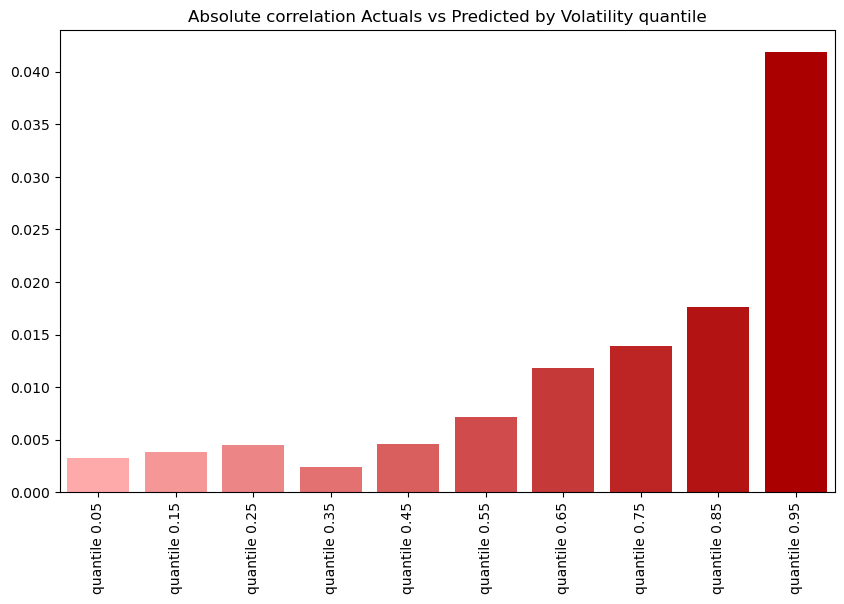

In [695]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FFAAAA", "#AA0000"])
plt.figure(figsize=(10, 6))
df_plot_corr.plot.bar()
plt.bar(df_plot_corr.index, df_plot_corr, color=cmap(np.linspace(0, 1, len(df_plot_corr))))
plt.title('Absolute correlation Actuals vs Predicted by Volatility quantile')

Dans cette dernière section du notebook, nous sauvegardons notre DataFrame de prédictions dans une base de données SQLite pour une utilisation ultérieure. SQLite est un système de gestion de base de données qui stocke les données dans un fichier sur disque, ce qui le rend parfait pour une utilisation légère et autonome dans des applications comme celle-ci.

La fonction `to_sql` de pandas permet de stocker facilement un DataFrame dans une base de données SQL. Ici, nous créons une nouvelle table appelée 'AR5_GARCH' dans notre base de données et y insérons les données de notre DataFrame de prédictions. Si une table du même nom existe déjà, nous la remplaçons (comme spécifié par l'argument `if_exists='replace'`).

Avec les prédictions stockées en toute sécurité dans une base de données, nous sommes prêts à les utiliser dans notre stratégie de trading optimisée.

In [1]:
import sqlite3
conn = sqlite3.connect('datas.db')
predictions.to_sql('AR5_GARCH', conn, if_exists='replace', index=True)

NameError: name 'predictions' is not defined